In [1]:
import numpy as np
import torch
from default_params import default_params
import sys
sys.path.append('..')
from rnn.reaching_task import Reaching
from rnn.utils import PC_traj
from rnn.train import *
from rnn.model import RNN
from torch.utils.data import DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)
np.random.seed(1)

### Here we will create a neuroscience model of a monkey performing a reaching task

The task is as follows:
1. The monkey sees a red dot stimulus appearing somewhere on the screen
2. The monkey memories location of the stimulus
3. After a delay, a cue comes on, and the Monkey moves cursor to the memorised location 
4. If this is the correct location, the Monkey receives a reward :)


### We now setup the task for the RNN
The stimulus position is defined by a phase $\theta \in [0, 2\pi)$

The model has three input channels. It receives $\sin(\theta),\cos(\theta)$ to input channel 1 and 2, respectively, during stimulus (Target) onset. During the Movement onset the model gets a constant input cue to channel 3, and it is tasked to output the stored location (also as $\sin(\theta),\cos(\theta)$).

The model will learn to perform this task by training it on batches of trials with different stimulus locations $\theta$.

![Monkey reach task](https://raw.githubusercontent.com/mackelab/pyrnn/main/tutorials/images/MonkeyReach.png)

image adapted from Gallego et al. 2018: https://www.biorxiv.org/content/10.1101/447441v1.full)

In [2]:
# Setup a task

task_params = {
        'onset': [25,50], # time till target stimulus onset (uniform between)
        'trial_len' : 350, # trial duration
        'stim_dur' : [25,50], # target stimulus duration
        'delay_dur': [50,200],# time till Movement onset cue 
        'n_stim': 6 #number of stimuli locations
}
reaching = Reaching(task_params)   
stimulus, target, loss_mask = reaching[1]


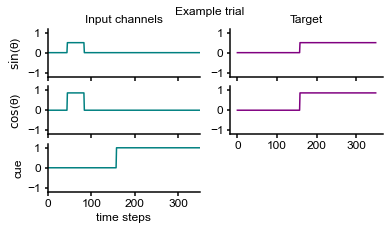

In [3]:
# Plot an example trial

fig,axs = plt.subplots(3,2,figsize=(6, 3))
fig.suptitle("Example trial")
axs[0,0].set_title("Input channels")
axs[0,1].set_title("Target")
axs[0,0].set_ylabel(r"$\sin(\theta)$")
axs[1,0].set_ylabel(r"$\cos(\theta)$")
axs[2,0].set_ylabel("cue")

for i in range(3):
    axs[i,0].plot(stimulus[:,i],color='teal')
    axs[i,0].set_xlim(0,task_params['trial_len'])
    axs[i,0].set_ylim(-1.2,1.2)

for i in range(2):
    axs[i,1].plot(target[:,i], color='purple')
    axs[i,0].set_xlim(0,task_params['trial_len'])
    axs[i,1].set_ylim(-1.2,1.2)
    axs[i,0].set_xticklabels([])
axs[0,1].set_xticklabels([])
axs[2,1].set_xlabel("time steps")
axs[2,0].set_xlabel("time steps")
fig.delaxes(axs[2,1])

### Initialize an RNN and start training it

The RNN consists of $N$ units, with activation $\mathbf{x}(t)\in \mathcal{R}^N$, recurrently connected via a connectivity matrix $\mathbf{J} \in \mathcal{R}^{N\times N}$, and receiving input $\mathbf{u}(t) \in \mathcal{R}^{3}$,
\begin{equation}\tau \frac{d\mathbf{x}}{dt}=-\mathbf{x}(t)+\mathbf{J} \tanh(\mathbf{x}(t))+\mathbf{I}\mathbf{u}(t)+\boldsymbol{\xi}(t),
\end{equation}
 where $\tau$ represents the time constant of the units, $\tanh$ is an elementwise non-linearity, $\mathbf{I}\in \mathcal{R}^{N\times3}$ represents the input weights, and $\boldsymbol{\xi}(t) \in {R}^N$ independent noise for each unit.

During training we discretize using the Euler-Maruyama method and use backpropagation through time to optimise the network parameters. We use a mean-squared error loss between the targets plotted above, and a linear readout from the network's activity: $\mathbf{W}^\mathsf{T}\tanh(\mathbf{x})$ 

In [4]:
# Initialise model

model_params, training_params, _ = default_params()
model_params['n_out']=2
model_params['n_inp']=3
training_params['n_epochs']=1200
rnn = RNN(model_params)

spectral_rad: 0.99999994


In [5]:
# Train

losses, reg_losses = train_rnn(rnn, training_params, reaching, sync_wandb=False)

epoch 1200 / 1200: time=91.5 s, task loss=0.01105, reg loss=0.00000
Done. Training took 91.5 sec.


Text(0, 0.5, 'loss')

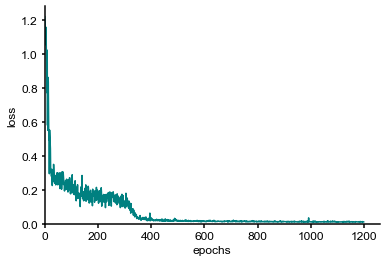

In [6]:
# Plot the loss

plt.plot(losses,color='teal')
plt.xlim(0)
plt.ylim(0)
plt.xlabel("epochs")
plt.ylabel("loss")

### Plot example output

Here we plot the output of the network for an example trial. We should see a good match to the target


test loss: 0.010638587176799774


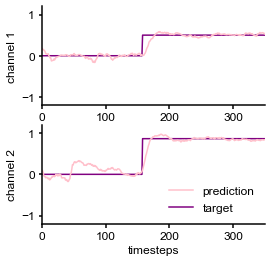

In [7]:
rates, pred = predict(rnn, stimulus, mse_loss, target, loss_mask)
fig, axs = plt.subplots(2,1, figsize=(4, 4))
for i in range(2):
    axs[i].set_ylabel("channel "+str(i+1))
    axs[i].plot(pred[0,:,i], label="prediction",color='pink',zorder=2)
    axs[i].plot(target[:,i], label="target",color='purple',zorder=0)
    axs[i].set_xlim(0, task_params['trial_len'])
    axs[i].set_xlabel("timesteps")
    axs[i].set_ylim(-1.2, 1.2)
axs[1].legend()

In [8]:
# save
save_rnn("reach_model", rnn, model_params, task_params, training_params)

### Let's look at low-dimensional dynamics!

We can understand how the model performs the task and stores stimulus information by looking at its fixed points.

See Sussillo & Barak 2013: https://pubmed.ncbi.nlm.nih.gov/23272922/
or Driscoll et al. 2022: https://www.biorxiv.org/content/10.1101/2022.08.15.503870v1

To find fixed points, here we will first simply present stimuli and run the dynamics forward for a long time, till the network converges (in the last cell we use a more through method). We will see that the model implements a 'ring' of fixed points which it can use to store information

We plot the fixed point (colorful dots below) and trajectories (grey lines) for different trials, by projecting on the first two principal components of the network activity

In [9]:
# Setup trials with the different stimuli presented

task_params['trial_len']=1000
reaching = Reaching(task_params)
dataloader = DataLoader(reaching, batch_size=reaching.__len__(), shuffle=False)
stimulus, target, loss_mask = next(iter(dataloader))
stimulus[:,100:,:]=0
rnn.params['noise_std']=0
rates_fp, pred = predict(rnn, stimulus)


In [10]:
# quick check if rates have converged, this should be a small number
print(np.linalg.norm(np.diff(rates_fp[:,-50:,:],axis=1)))

0.00030357522


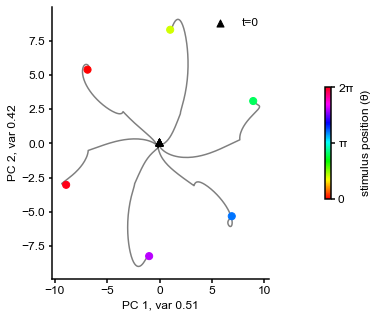

In [11]:
# plot the trajectories in PC space

z, varexp = PC_traj(rates_fp, n_comp=3)
alpha=0.2
cmap = mpl.colormaps['hsv']
fig = plt.figure(figsize=(5,5))
t_end = -2
ax = fig.add_subplot(111)

# add final points
cax=ax.scatter(z[:, t_end , 0], z[:, t_end , 1],c=np.arange(task_params['n_stim']), cmap=cmap,vmin=0, vmax=task_params['n_stim']-1,s=50,alpha=1)

# add trajectories
for trial_i in range(task_params['n_stim']):
    ax.plot(z[trial_i, :t_end, 0], z[trial_i, :t_end, 1], color='black', alpha=.5,zorder=-2)

# add starting positions
ax.scatter(z[:, 0 , 0], z[:, 0 , 1],c='black', s=50,alpha=1,marker='^',label='t=0')

ax.set_xlabel("PC 1, var {:.2f}".format(varexp[0]))
ax.set_ylabel("PC 2, var {:.2f}".format(varexp[1]))

cbar=fig.colorbar(cax,fraction=0.02, pad=0.2,ticks=[0,task_params['n_stim']/2-0.5,task_params['n_stim']-1])
cbar.ax.set_yticklabels(['0',r'$\pi$',r'$2\pi$'])
cbar.ax.set_ylabel(r'stimulus position ($\theta$)')
plt.legend()

### Use the [the fixed point finder toolbox](https://github.com/mattgolub/fixed-point-finder/blob/master/FixedPoints.py) to find fixed points

In this repo we included a pytorch version of the original tensorflow toolbox

It finds fixed points by using gradient descent to find minima of $q=\lVert \frac{d\mathbf{x}}{dt}\rVert$. Again, it also finds a ring of fixed points. One could next investigate how input changes the stability of these points

In [12]:
from pytorch_fixed_point_finder.FixedPointFinder import FixedPointFinder
from pytorch_fixed_point_finder.plot_utils import plot_fps

NOISE_SCALE = 0.05 # Standard deviation of noise added to initial states
N_INITS = 1024 # The number of initial states to provide

'''Fixed point finder hyperparameters. See FixedPointFinder.py for detailed
descriptions of available hyperparameters.'''
fpf_hps = {'max_iters':50000}

# Setup the fixed point finder
fpf = FixedPointFinder(rnn.rnn, **fpf_hps)

# Study the system in the absence of input pulses (e.g., all inputs are 0)
inputs = np.zeros([1,3])

# sample trajectories
task_params['trial_len']=25
reaching = Reaching(task_params)
dataloader = DataLoader(reaching, batch_size=reaching.__len__(), shuffle=False)
stimulus, target, loss_mask = next(iter(dataloader))
rates, pred = predict(rnn, stimulus)

'''Draw random, noise corrupted samples of those state trajectories
to use as initial states for the fixed point optimizations.'''
initial_states = fpf.sample_states(rates_fp,
    n_inits=N_INITS,
    noise_scale=NOISE_SCALE)


# Run the fixed point finder
unique_fps, all_fps = fpf.find_fixed_points(torch.from_numpy(initial_states).to(torch.float32), 
                                            torch.from_numpy(inputs).to(torch.float32))


No display found. Using non-interactive Agg backend.

Searching for fixed points from 1024 initial states.

	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		44836 iters
		q = 1.00e-12 +/- 3.98e-12
		dq = 5.97e-15 +/- 1.83e-14
		learning rate = 4.20e+00
		avg iter time = 1.39e-03 sec
	Identified 17 unique fixed points.
		initial_states: 0 outliers detected (of 1024).
		fixed points: 0 outliers detected (of 17).
	Computing recurrent and input Jacobian at 17 unique fixed points.
(17, 3)
(17, 100)
(17, 100, 100)
(17, 100, 3)
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



/Users/matthijs/pyrnn2/pyrnn/tutorials/../pytorch_fixed_point_finder/plot_utils.py:155: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/matthijs/pyrnn2/pyrnn/tutorials/../pytorch_fixed_point_finder/plot_utils.py:156: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.pause(1e-10)


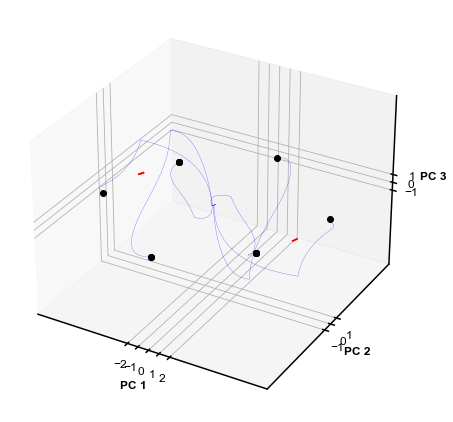

In [16]:
# Visualize identified fixed points with overlaid RNN state trajectories
# All visualized in the 3D PCA space fit to the example RNN states.
fig = plot_fps(unique_fps, rates_fp,
    plot_start_time=0)
